In [7]:
import os
os.chdir('/Users/adityapatel/personal/projects/git/clash/')

In [9]:
import pymysql
import pymysql.cursors
import config
import pandas as pd
import seaborn as sns
import sqlalchemy
import matplotlib.pylab as plt

In [10]:
sns.set()

In [11]:
%matplotlib inline

In [12]:
sns.set()

In [96]:
connection = pymysql.connect(host=config._mysql_host,
                             user=config._mysql_user,
                             password=config._mysql_password,
                             db=config._mysql_db,
                             port=config._mysql_port,
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [101]:
activity_sql = '''
with temp_modified_table as (
select
  player_tag, player_name, date(created_time) as start_date, war_stars as metric_value ,
  rank() over (PARTITION BY player_tag, date(created_time)order by player_tag, created_time) as hour_rank,
  rank() over (PARTITION BY player_tag, date(created_time)order by player_tag, created_time desc) as hour_rank_desc
from player_stats_historic
				WHERE created_time >= '2019-05-01'),

tmp_m_player_stats as (
SELECT *
                            FROM (SELECT player_tag,
                                         player_name,
                                         start_date,
                                            hour_rank,
                                         'war_stars'  AS metric_name,
                                         lead(metric_value) OVER(PARTITION BY player_tag ORDER BY start_date) -
                                         metric_value AS metric_value
                                  FROM temp_modified_table
                                  WHERE
				                                  hour_rank = 1 or (start_date = '2019-05-04' and hour_rank = 2) and
					                               start_date >= '2019-05-01'
                                  ORDER BY 1, 2, 3, 4) t
                            WHERE t.metric_value IS NOT NULL
)
select m.player_tag,
							m.player_name,
							metric_name,
						 clan_name,
       psc.clan_tag,
       csc.clan_name,
							psc.town_hall_level,
							psc.queen_level,
							psc.king_level,
							psc.warden_level,
							psc.exp_level,
							sum(metric_value) as total_stars_earned,
							max(start_date)
from tmp_m_player_stats m
left join player_stats_current psc ON (psc.player_tag = m.player_tag COLLATE utf8_unicode_ci)
left join clan_stats_current csc on psc.clan_tag  = csc.clan_tag
where csc.clan_tag in ('#YUPCJJCR','#9L8QLQ9U', '#28GP9VJLL', '#GP0UP0CG', '#9JG02C0Q', '#8UGQ208P', '#9YRCG02Y', '#9LR0V8LG')
and metric_name = 'war_stars'
and metric_value > 0
and start_date >= '2019-05-01'
GROUP BY 1,2,3,4,5,6,7,8,9,10,11
;
'''

In [102]:
with connection.cursor() as cursor:
    # Create a new record
    cursor.execute(activity_sql)
    results = cursor.fetchall()
    activity_df = pd.DataFrame(results)

In [50]:
player_sql = '''
select psc.*, csc.clan_name
from
player_stats_current psc
left join clan_stats_current csc on psc.clan_tag  = csc.clan_tag
'''

In [51]:
with connection.cursor() as cursor:
    # Create a new record
    cursor.execute(player_sql)
    results = cursor.fetchall()
    df = pd.DataFrame(results)

In [65]:
season_df = df[df['clan_tag'].isin(['#YUPCJJCR','#9L8QLQ9U', '#28GP9VJLL', '#GP0UP0CG', '#9JG02C0Q', '#8UGQ208P', '#9YRCG02Y', '#9LR0V8LG'])]

In [66]:
df.shape

(532, 25)

In [67]:
season_df.columns

Index(['achv_dark_looted', 'achv_elixer_looted', 'achv_gold_looted',
       'achv_th_destroyed', 'achv_total_donations', 'attack_wins',
       'battle_machine_Level', 'clan_name', 'clan_tag', 'created_time',
       'current_league', 'current_trophies', 'defense_wins', 'donations_given',
       'donations_received', 'exp_level', 'king_level', 'player_id',
       'player_name', 'player_tag', 'queen_level', 'town_hall_level',
       'updated_time', 'war_stars', 'warden_level'],
      dtype='object')

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns    

In [69]:
big_th_df = season_df[season_df['town_hall_level'] >= 9]

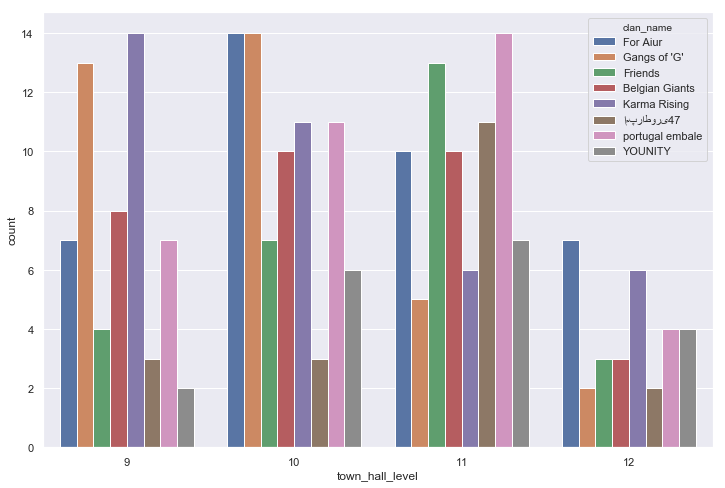

In [70]:
plt.figure(figsize=(12,8))
sns.countplot(x='town_hall_level', hue='clan_name', data=big_th_df)

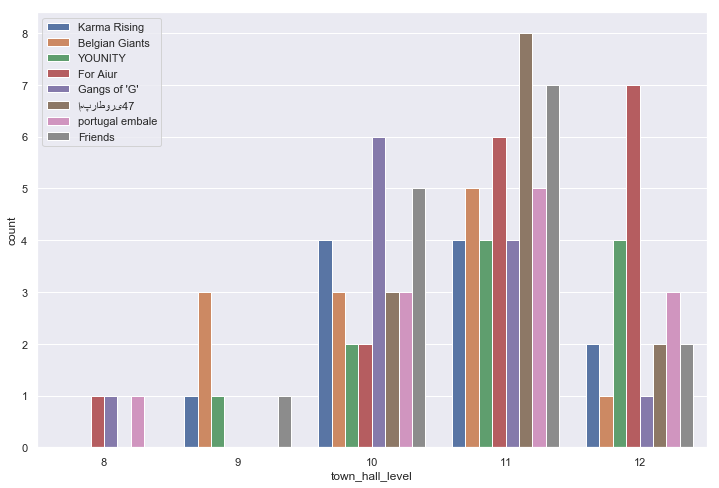

In [103]:
plt.figure(figsize=(12,8))
sns.countplot(x='town_hall_level', hue='clan_name', data=activity_df)
plt.legend(loc='upper left')

In [115]:
# active_th_df = activity_df.groupby('clan_name')['player_tag'].count().reset_index()

In [114]:
# active_th_df.head()

In [113]:
# plt.figure(figsize=(12,8))
# sns.barplot(x='clan_name', y='player_tag', data=active_th_df)

In [116]:
# activity_df

Text(0.5, 1.0, 'GOOD ATTACKS')

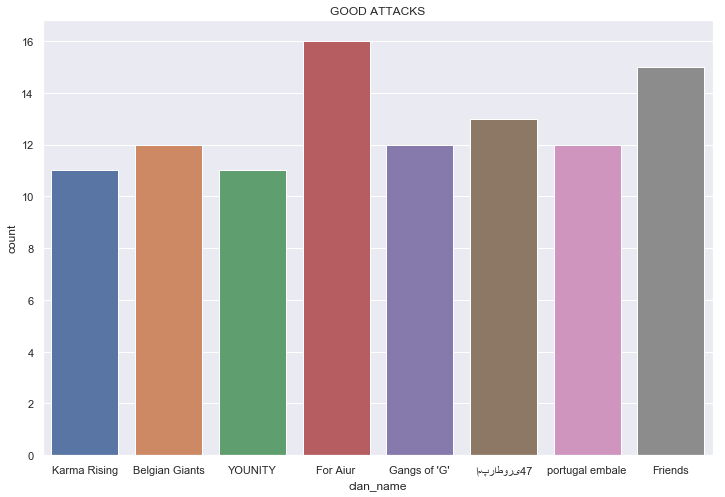

In [121]:
plt.figure(figsize=(12,8))
sns.countplot(x='clan_name', data=activity_df).set_title(label="GOOD ATTACKS")

In [122]:
activity_df.head(1)

,clan_name,clan_tag,csc.clan_name,exp_level,king_level,max(start_date),metric_name,player_name,player_tag,queen_level,total_stars_earned,town_hall_level,warden_level
0,Karma Rising,#9JG02C0Q,Karma Rising,160,31,2019-05-03,war_stars,mcshamus,#202R29L2P,40.0,2,11,7.0


In [ ]:
activity_df

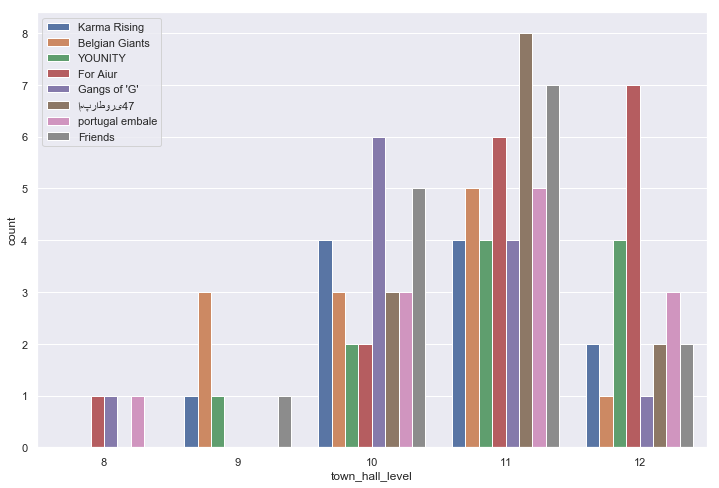

In [134]:
plt.figure(figsize=(12,8))
sns.countplot(x='town_hall_level', hue='clan_name', data=activity_df)
plt.legend(loc='upper left')

In [135]:
activity_df.columns

Index(['clan_name', 'clan_tag', 'csc.clan_name', 'exp_level', 'king_level',
       'max(start_date)', 'metric_name', 'player_name', 'player_tag',
       'queen_level', 'total_stars_earned', 'town_hall_level', 'warden_level'],
      dtype='object')

In [150]:
grouped_by_clan = activity_df.groupby(['clan_name', 'town_hall_level'])\
                            .agg({
                                   'queen_level': 'median',
                                        'king_level': 'mean',
    'warden_level': 'median',
    'exp_level': 'mean'
    
}).reset_index()

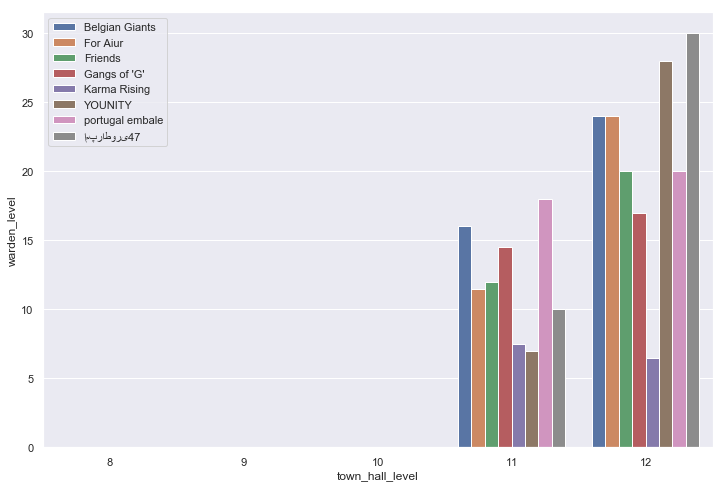

In [151]:
plt.figure(figsize=(12,8))
sns.barplot(x='town_hall_level', y='warden_level', hue='clan_name', data=grouped_by_clan)
plt.legend(loc='upper left')

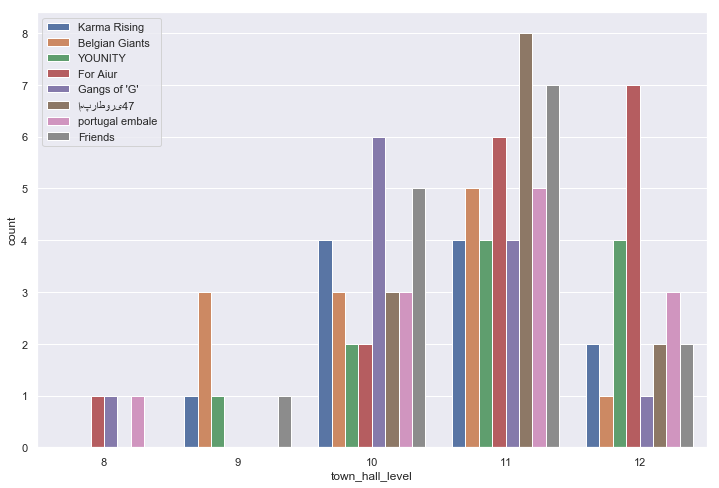

In [146]:
plt.figure(figsize=(12,8))
sns.countplot(x='town_hall_level', hue='clan_name', data=activity_df)
plt.legend(loc='upper left')